<a href="https://colab.research.google.com/github/francescopatane96/protein-xAI/blob/main/see_me.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install captum

In [98]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torch.nn.utils.rnn as rnn_utils


class xAInet(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.hidden_dim = 25
    self.batch_size = 32
    self.embedding_dim = 512

    self.embedding_layer = nn.Embedding(24, self.embedding_dim, padding_idx=0)
    self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)

    self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
    self.gru = nn.GRU(self.embedding_dim, self.hidden_dim, num_layers=2,
                      bidirectional=True, dropout=.2)
    
    self.block_seq = nn.Sequential(nn.Linear(15050, 2048),
                                   nn.BatchNorm1d(2048),
                                   nn.LeakyReLU(),
                                   nn.Linear(2048, 1024),
                                   nn.BatchNorm1d(1024),
                                   nn.LeakyReLU(),
                                   nn.Linear(1024, 256),
                                   nn.BatchNorm1d(256),
                                   nn.ReLU(),
                                   nn.Linear(256, 8),
                                   nn.Linear(8, 2),
                                   nn.Softmax(dim=1))
    
    
  def forward(self, seq):
        seq = seq.long()
        embeddings = self.embedding_layer(seq)
        output = self.transformer_encoder(embeddings).permute(1, 0, 2)
        output, hn = self.gru(output)
        output = output.permute(1, 0, 2)
        hn = hn.permute(1, 0, 2)
       
        output = output.reshape(output.shape[0], -1)
        hn = hn.reshape(output.shape[0], -1)
        
        output = torch.cat([output, hn], 1)
        output = self.block_seq(output)
       
       
        return output


In [31]:
def model_output(inputs):

    #inputs = inputs[0].unsqueeze(0)
  
    out = model(inputs)
    # Apply softmax to convert prediction scores to probabilities
    probabilities = torch.softmax(out, dim=1)
    

    # Get the predicted classes by selecting the class with the highest probability
    predicted_classes = torch.argmax(probabilities, dim=1)  
    return predicted_classes


In [251]:
def construct_input_and_baseline(text):

    max_length = 512
    #baseline_token_id = rnn_utils.pad_sequence()
    

    input_ids = []
    token_list = []
    
    aa_dict = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
               'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 'O': 16, 'S': 17, 'U': 18, 'T': 19,
               'W': 20, 'Y': 21, 'V': 22, 'X': 23, 'PAD': 0}
    
    for char in text:
      if char in aa_dict:
        input_ids.append(aa_dict[char])
        token_list.append(char)

    baseline_token_id = 23
    baseline_input_ids = [baseline_token_id] * len(input_ids)

    input_ids_tensor = torch.tensor([input_ids], device='cpu')
    baseline_input_ids_tensor = torch.tensor([baseline_input_ids], device='cpu')

    return input_ids_tensor, baseline_input_ids_tensor, token_list

In [252]:
text = 'MSKSKMLVFKSKKKKKKKKKKKKKKK'

input_ids, baseline_input_ids, all_tokens = construct_input_and_baseline(text)

print(f'original text: {input_ids}')
print(f'baseline text: {baseline_input_ids}')
print(f'all tokens: {all_tokens}')


original text: tensor([[13, 17, 12, 17, 12, 13, 11, 22, 14, 12, 17, 12, 12, 12, 12, 12, 12, 12,
         12, 12, 12, 12, 12, 12, 12, 12]])
baseline text: tensor([[23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23]])
all tokens: ['M', 'S', 'K', 'S', 'K', 'M', 'L', 'V', 'F', 'K', 'S', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K']


In [253]:
desired_length = 299
padded_sequences = [seq[:desired_length] if len(seq) >= desired_length else torch.cat((seq, torch.zeros(desired_length - len(seq)))) for seq in input_ids]
# Apply pad_sequence on the padded_sequences
    #data = pad_sequence(padded_sequences, batch_first=True)
    
input_ids = rnn_utils.pad_sequence(padded_sequences, batch_first=True)

padded_sequences = [seq[:desired_length] if len(seq) >= desired_length else torch.cat((seq, torch.zeros(desired_length - len(seq)))) for seq in baseline_input_ids]
# Apply pad_sequence on the padded_sequences
    #data = pad_sequence(padded_sequences, batch_first=True)
    
baseline_input_ids = rnn_utils.pad_sequence(padded_sequences, batch_first=True)

In [254]:
print(f'original text: {input_ids}')
print(f'baseline text: {baseline_input_ids}')
print(f'all tokens: {all_tokens}')

original text: tensor([[13., 17., 12., 17., 12., 13., 11., 22., 14., 12., 17., 12., 12., 12.,
         12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.

In [ ]:
model = xAInet()
model.eval()

In [257]:
from captum.attr import LayerIntegratedGradients

ig = LayerIntegratedGradients(model, model.embedding_layer)


attribution, delta = ig.attribute(inputs=input_ids, baselines=baseline_input_ids, target=model_output(input_ids), return_convergence_delta=True, internal_batch_size=1)  

In [258]:
def summarize_attributions(attributions):

    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    
    return attributions

attributions_sum = summarize_attributions(attribution)

print(attributions_sum.size())
print(attribution.size())

torch.Size([299])
torch.Size([1, 299, 512])


In [ ]:
from captum.attr import visualization as viz          #NON funziona

score_vis = viz.VisualizationDataRecord(
                        word_attributions = attributions_sum,
                        pred_prob = torch.max(model(input_ids)[0]),
                        pred_class = torch.argmax(model(input_ids)[0]).numpy(),
                        true_class = 0,
                        attr_class = 'seq',
                        attr_score = attributions_sum.sum(),       
                        raw_input_ids = input_ids,
                        convergence_score = delta)

viz.visualize_text([score_vis])

In [259]:
attr = attributions_sum.tolist()

In [270]:
aa_dict = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
               'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 'O': 16, 'S': 17, 'U': 18, 'T': 19,
               'W': 20, 'Y': 21, 'V': 22, 'X': 23, 'PAD': 0}

In [284]:
def generate_text_from_tokens(input_ids, aa_dict):
    text = []
    for token in input_ids:
        if token.item() in aa_dict.values():
            aminoacido = list(aa_dict.keys())[list(aa_dict.values()).index(token.item())]
            text.append(aminoacido)
    return text



In [285]:
generated_text = generate_text_from_tokens(input_ids[0], aa_dict)
print(generated_text)




['M', 'S', 'K', 'S', 'K', 'M', 'L', 'V', 'F', 'K', 'S', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'K', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', '

In [ ]:
attributions_sum = attributions_sum.tolist()

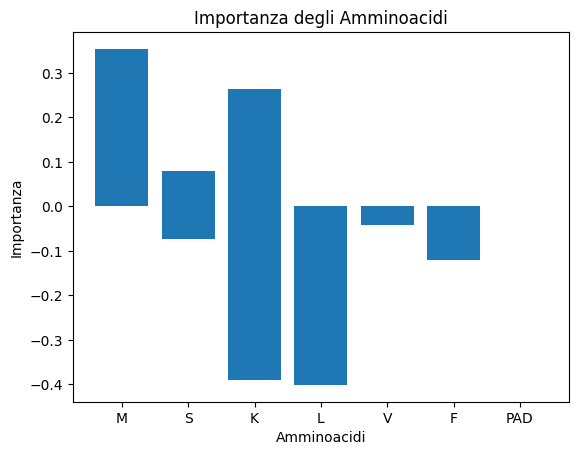

In [287]:
import matplotlib.pyplot as plt

# Etichette degli amminoacidi


# Creazione del grafico a barre
plt.bar(generated_text, attributions_sum)
plt.xlabel('Amminoacidi')
plt.ylabel('Importanza')
plt.title('Importanza degli Amminoacidi')
plt.show()
